# Connect to Drive
Add [this Google folder](https://drive.google.com/drive/folders/1K54qqwYtk1ADJlkptJNF-FfyjQ7R6KGC?usp=sharing) to your drive then adjust the paths in the `current_directory` variable 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
current_directory = "/content/drive/MyDrive/AI/Trained models"
os.chdir("/content/drive/MyDrive/AI/Trained models")

# Load holdout data predictions from the different models for evaluation

In [ ]:
import pandas as pd
df = pd.read_excel("holdout_with_compiled_predictions.xlsx")
preds_df = df.drop(columns=["response","Label","GLTR Category 1","GLTR Category 3","Mean Perplexity","sum_mistakes","TextBlob_Subjectivity","Formality Score"], axis=1)
y_true = df["Label"].values
preds_df.head(1)

,SVM_TFIDF,SVM_GLOVE,SVM_FASTTEXT,SVM_W2V,BERT,NB,RNNPerplexityClassifier,CNNPerplexityClassifier,CNNGLTRClassifer,CNNTextClassifier
0,0,1,1,1,0.00549,2.530000e-13,0.516926,0.50141,0.498863,0.648621


# Evaluate Accuracy

To be more sure that the text is AI-written, the threshold to classify as AI is if the probability of being AI is more than 0.6

In [ ]:
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score  
import numpy as np
def evaluate(pred, y_true, threshold):
  y_pred = np.array(pred)
  discrete = (y_pred > threshold).astype("int32")
  accuracy = accuracy_score(discrete, y_true)
  f1score = f1_score(discrete, y_true)
  roc_auc = roc_auc_score(discrete, y_true)
  print(classification_report(discrete, y_true, target_names=["Human", "ChatGPT"]))
  return [accuracy, roc_auc, f1score]

In [ ]:
col_perf_lst = []
threshold = 0.6
for clf in preds_df.columns:
  print(clf)
  pred = preds_df[clf].tolist()
  eval_result = evaluate(pred, y_true,threshold)
  result_lst = [clf]
  result_lst.extend(eval_result)
  col_perf_lst.append(result_lst)

col_perf_lst.sort(key=lambda a:  (a[1], a[2], a[3]), reverse=True)
col_perf_lst

SVM_TFIDF
              precision    recall  f1-score   support

       Human       0.93      0.93      0.93      1000
     ChatGPT       0.93      0.93      0.93      1000

    accuracy                           0.93      2000
   macro avg       0.93      0.93      0.93      2000
weighted avg       0.93      0.93      0.93      2000

SVM_GLOVE
              precision    recall  f1-score   support

       Human       0.75      0.71      0.73      1063
     ChatGPT       0.69      0.74      0.71       937

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000

SVM_FASTTEXT
              precision    recall  f1-score   support

       Human       0.72      0.70      0.71      1023
     ChatGPT       0.70      0.71      0.71       977

    accuracy                           0.71      2000
   macro avg       0.71      0.71      0.71      2000
weighted avg       0.71      0.71      0.

[['RNNPerplexityClassifier', 0.964, 0.9641188144164906, 0.9642857142857142],
 ['SVM_TFIDF', 0.932, 0.9319999999999999, 0.932],
 ['BERT', 0.8925, 0.8991421240869306, 0.8850881881346873],
 ['CNNGLTRClassifer', 0.8415, 0.8555813781563704, 0.855843565256935],
 ['CNNPerplexityClassifier', 0.793, 0.7947935237987919, 0.7845993756503641],
 ['CNNTextClassifier', 0.787, 0.7961742949607027, 0.7664473684210527],
 ['SVM_GLOVE', 0.7205, 0.7213786518692692, 0.7114093959731543],
 ['SVM_W2V', 0.7165, 0.7167082566346259, 0.7120365667851702],
 ['SVM_FASTTEXT', 0.7095, 0.7096108841577194, 0.7061203844208397],
 ['NB', 0.4395, 0.4391934743039663, 0.4188698807672369]]

# Check if models are correlated by checking if their errors are correlated

High correlation is expected given that these models were trained on similar data and have similar model structure. Furthermore, each model differed mainly by 1 feature, which might not have significantly diverisfied the models given that the text features would still dominate.

In [ ]:
from sklearn.metrics import log_loss
residual_col_name_lst = []
for col in preds_df:
  new_col_name = col + "_Residuals"
  residual_col_name_lst.append(new_col_name)
  preds_df[new_col_name] = y_true - preds_df[col].tolist()

residual_df = preds_df[residual_col_name_lst]

We can observe that the SVM models are correlated with each other. The Keras Models are correlated with each other. This is likely due to similar features used as well as similar model structure. Meanwhile, NB is more correlated with the Keras Models at 0.7 correlation with Keras Models. BERT Is not correlated with the rest, likely due to different embedding (BERT embeddings) and transformer architecture.

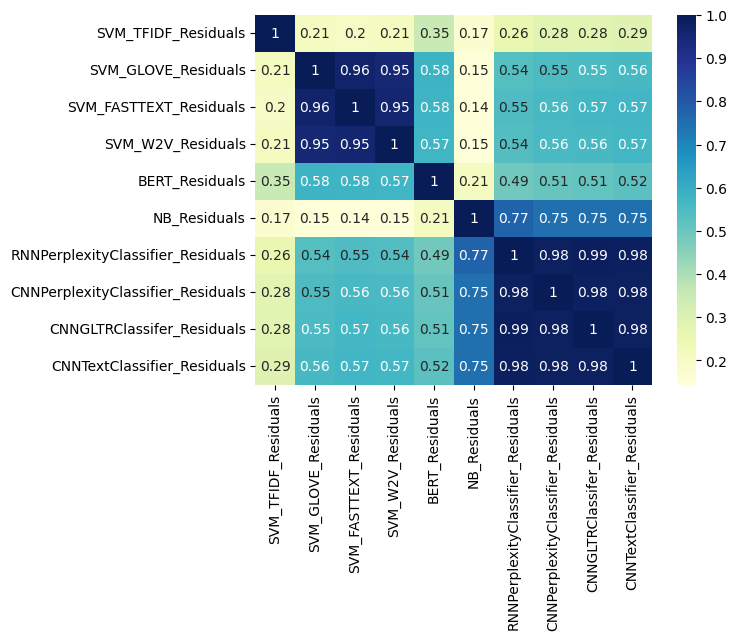

In [ ]:
import seaborn as sb
corr = residual_df.corr()
dataplot = sb.heatmap(corr, cmap="YlGnBu", annot=True)

# Final Model Choices and Rationale
As such the correlated groups are:
- SVM Word Embedding Models
- SVM TFIDF
- BERT
- Keras Models + Naive Bayes

Out of the correlated groups, we will pick the model with highest accuracy on holdout dataset. We will choose based on the holdout dataset as this is unseen data by all the models.

```
[['RNNPerplexityClassifier', 0.964, 0.9641188144164906, 0.9642857142857142],
 ['SVM_TFIDF', 0.932, 0.9319999999999999, 0.932],
 ['BERT', 0.91, 0.9114813327980731, 0.9072164948453608],
 ['CNNGLTRClassifer', 0.8415, 0.8555813781563704, 0.855843565256935],
 ['CNNPerplexityClassifier', 0.793, 0.7947935237987919, 0.7845993756503641],
 ['CNNTextClassifier', 0.787, 0.7961742949607027, 0.7664473684210527],
 ['SVM_GLOVE', 0.7205, 0.7213786518692692, 0.7114093959731543],
 ['SVM_W2V', 0.7165, 0.7167082566346259, 0.7120365667851702],
 ['SVM_FASTTEXT', 0.7095, 0.7096108841577194, 0.7061203844208397],
 ['NB', 0.439, 0.4389117886227713, 0.42813455657492355]]

```

Chosen models: BERT, RNNPerplexityClassifier, SVM_TFIDF

# Grid Search To Get Optimal Weights


In [ ]:
from itertools import product
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score  

# normalize a vector to have unit norm
def normalize(weights):
 # calculate l1 vector norm
 result = np.linalg.norm(weights, 1)
 # check for a vector of all zeros
 if result == 0.0:
  return weights
 # return normalized vector (unit norm)
 return weights / result

#prediction compiled list is a list of prediction from each model for each test data point
def get_scores(prediction_compiled_list, threshold, y_true, weights):
  #Apply weights to predictions to get weighted average
  yhats = np.array(prediction_compiled_list)
  avg = np.average(yhats,axis=1,weights=weights)
  #Convert probabilities to 0 or 1 classification outcome
  discrete = (avg > threshold).astype("int32")
  return {"accuracy":accuracy_score(discrete, y_true), "f1":f1_score(discrete, y_true),"roc-auc":roc_auc_score(discrete,y_true)}

#preds is a list of prediction from each model for each test data point
def grid_search(num_models, preds, testy, threshold):
  tracker = []
  w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  # iterate all possible combinations (cartesian product)
  for weights in product(w, repeat=num_models):
    # skip if all weights are equal
    if len(set(weights)) == 1:
      continue
    # hack, normalize weight vector
    weights = normalize(weights)
    # evaluate weights
    score_dict = get_scores(preds, threshold, testy, weights)
    accuracy = score_dict["accuracy"]
    f1 = score_dict["f1"] 
    roc_auc = score_dict["roc-auc"]
    tracker.append((accuracy, f1, roc_auc, weights))
  return tracker

#outputs is a a list of predictions from each model [[model_1_preds], [model_2_preds]]
#we want to output [[model_1_pred_for_row1, model_2_pred_for_row1], [...]]
def get_prediction_compiled_list(outputs):
  prediction_compiled_lst = []
  num_rows_predicted = len(outputs[0])
  for i in range(num_rows_predicted):
    prediction_lst = []
    for output in outputs:
      prediction_lst.append(output[i])
    prediction_compiled_lst.append(prediction_lst)
  return prediction_compiled_lst
    

In [ ]:
outputs = [preds_df['BERT'], preds_df['RNNPerplexityClassifier'], preds_df['SVM_TFIDF']]

In [ ]:
threshold = 0.6
num_models = 3
preds = get_prediction_compiled_list(outputs)
tracker = grid_search(num_models, preds, y_true, threshold)

Sort by 1. Prioritise weights that do not zero out weights for any model 2. Prioritise weights that give higher accuracy followed by ROC_AUC then F1 Score

In [ ]:
#sort by accuracy, roc_auc score, f1 score then choose arrays that have more models with non-zero weights for diversification
#as we are using a holdout set of small size

def get_count_of_weights_above_zero(weights):
  count = 0
  for weight in weights:
    if weight > 0:
      count += 1
  return count

tracker.sort(key=lambda a:  (get_count_of_weights_above_zero(a[3]),a[0], a[2], a[1],), reverse=True)
print(tracker[:10])
best_weights = tracker[0][3]
best_weights

[(0.965, 0.9640287769784172, 0.9663599054843924, array([0.08333333, 0.83333333, 0.08333333])), (0.9625, 0.9615187275525912, 0.9637060995649686, array([0.09090909, 0.81818182, 0.09090909])), (0.96, 0.9588900308324769, 0.9613452828447753, array([0.1, 0.8, 0.1])), (0.9575, 0.9562532166752445, 0.9589912626122272, array([0.11111111, 0.77777778, 0.11111111])), (0.9555, 0.9541000515729757, 0.9572012458357548, array([0.125, 0.75 , 0.125])), (0.9535, 0.9520371325425476, 0.9551937760406473, array([0.14285714, 0.71428571, 0.14285714])), (0.9535, 0.9520371325425476, 0.9551937760406473, array([0.14285714, 0.71428571, 0.14285714])), (0.952, 0.9508196721311476, 0.9530438129450254, array([0.07692308, 0.76923077, 0.15384615])), (0.9515, 0.9498708010335918, 0.9534156812532952, array([0.15384615, 0.69230769, 0.15384615])), (0.9515, 0.9503328213005633, 0.9524995715535618, array([0.08333333, 0.75      , 0.16666667]))]


array([0.08333333, 0.83333333, 0.08333333])

Test out the optimal weights found
In order of accuracy, ROC_AUC and F1_Score, the models individually did: 
```
'RNNPerplexityClassifier', 0.964, 0.9641188144164906, 0.9642857142857142],
'BERT', 0.91, 0.9114813327980731, 0.9072164948453608],
'SVM_GLOVE', 0.7205, 0.7213786518692692, 0.7114093959731543]

```
Together, with weights of [0.08333333, 0.83333333, 0.08333333] for BERT,RNN and SVM respectively, the ensemble achieved:

Accuracy:0.965

ROC_AUC:0.964

F1_Score:0.966

Even though the RNN Perplexity Classifier had comparable individual performance, this was one a small holdout dataset of 1000 pairs of human and AI written responses. We also want to aim for variance by ensuring that the ensemble can generalise well. This could be done with the help of BERT and SVM_GLOVE which are uncorrelated and high-performing as well.

# Issue: Resolving Local Loading of Keras Models 

However, due to being unable to load the Keras Models locally due to some issues to be resolved and the longer processing time of perplexity feature (especially for longer texts), we will exclude the Keras Models from the local demo but make it available on Google Colab.

As such, the next best model selections will be SVM_GLOVE instead of RNNPerplexityClassifier

In [ ]:
demo_outputs = [preds_df['BERT'], preds_df['SVM_TFIDF']]
demo_preds = get_prediction_compiled_list(demo_outputs)
num_models = 2
threshold = 0.6
adjusted_tracker = grid_search(num_models, demo_preds, y_true, threshold)

adjusted_tracker.sort(key=lambda a:  (get_count_of_weights_above_zero(a[3]),a[0], a[2], a[1],), reverse=True)
print(adjusted_tracker[:10])
best_weights = adjusted_tracker[0][3]
best_weights

[(0.942, 0.9406345957011258, 0.9429372552320712, array([0.41176471, 0.58823529])), (0.9415, 0.9400307534597643, 0.9425625927852774, array([0.41666667, 0.58333333])), (0.941, 0.9392378990731205, 0.9424885314196959, array([0.42857143, 0.57142857])), (0.941, 0.9392378990731205, 0.9424885314196959, array([0.42857143, 0.57142857])), (0.938, 0.9359504132231404, 0.939801426643532, array([0.4375, 0.5625])), (0.9365, 0.934299017071909, 0.938468284127448, array([0.44444444, 0.55555556])), (0.9365, 0.934299017071909, 0.938468284127448, array([0.44444444, 0.55555556])), (0.9345, 0.9320186818889465, 0.93682785564272, array([0.46153846, 0.53846154])), (0.9345, 0.9320891653706584, 0.9367014118169693, array([0.45454545, 0.54545455])), (0.934, 0.9314641744548287, 0.936389669832, array([0.46666667, 0.53333333]))]


array([0.41176471, 0.58823529])

In [ ]:
demo_outputs = [preds_df['BERT'], preds_df['SVM_GLOVE'], preds_df['SVM_TFIDF']]
demo_preds = get_prediction_compiled_list(demo_outputs)
num_models = 3
threshold = 0.6
adjusted_tracker = grid_search(num_models, demo_preds, y_true, threshold)

adjusted_tracker.sort(key=lambda a:  (get_count_of_weights_above_zero(a[3]),a[0], a[2], a[1],), reverse=True)
print(adjusted_tracker[:10])
best_weights = adjusted_tracker[0][3]
best_weights

[(0.9405, 0.9392547217968351, 0.9412417273436648, array([0.35294118, 0.05882353, 0.58823529])), (0.94, 0.9387129724208376, 0.9407775315656818, array([0.33333333, 0.08333333, 0.58333333])), (0.94, 0.9387129724208376, 0.9407775315656818, array([0.23529412, 0.17647059, 0.58823529])), (0.94, 0.9387129724208376, 0.9407775315656818, array([0.29411765, 0.11764706, 0.58823529])), (0.9395, 0.9380440348182283, 0.9404730048677529, array([0.25      , 0.16666667, 0.58333333])), (0.9395, 0.9380440348182283, 0.9404730048677529, array([0.17647059, 0.23529412, 0.58823529])), (0.937, 0.935318275154004, 0.9381848518393737, array([0.35714286, 0.07142857, 0.57142857])), (0.935, 0.9331275720164609, 0.9363684514637904, array([0.28571429, 0.14285714, 0.57142857])), (0.935, 0.9331275720164609, 0.9363684514637904, array([0.16666667, 0.25      , 0.58333333])), (0.935, 0.9331275720164609, 0.9363684514637904, array([0.11764706, 0.29411765, 0.58823529]))]


array([0.35294118, 0.05882353, 0.58823529])

Together, they did:

Accuracy:0.9405

ROC_AUC:0.939

F1_Score:0.94

With weights:

BERT: 0.35294118

SVM_GLOVE: 0.05882353

SVM_TFIDF: 0.58823529